### Get the data

#### Question 1

- Programmatically download and load into your favorite analytical tool the trip data for September 2015.
- Report how many rows and columns of data you have loaded.

#### Fetch data via URL

In [1]:
import os
from six.moves import urllib

TAXI_URL = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
TAXI_DIR = 'datasets/'

def fetch_taxi_data(taxi_url=TAXI_URL, taxi_dir=TAXI_DIR):
    if not os.path.isdir(taxi_dir):
        os.makedirs(taxi_dir)
    taxi_path = os.path.join(taxi_dir, "green_tripdata_2015-09.csv")
    urllib.request.urlretrieve(taxi_url, taxi_path)

fetch_taxi_data()

# import pandas as pd

# url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
# df=pd.read_csv(url)


#### Load data

In [2]:
import pandas as pd
import os
from six.moves import urllib

TAXI_URL = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
TAXI_DIR = 'datasets/'
TAXI_PATH = os.path.join(TAXI_DIR, "green_tripdata_2015-09.csv")

def load_taxi_data(taxi_path=TAXI_PATH):
    return pd.read_csv(taxi_path)


df = load_taxi_data()
row, column = df.shape

print("row %d, column: %d" % (row, column))

row 1494926, column: 21


#### Answers to Question 1

- use liburl to download data from an URL
- number of rows: 1494926, number of columns: 21


### Explore Variable - Trip Distance
#### Question 2

- Plot a histogram of the number of the trip distance ("Trip Distance").
- Report any structure you find and any hypotheses you have about that structure.

##### Answers to Q2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
print(df['Trip_distance'].describe())
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(df['Trip_distance'], bins=30, log=True)
plt.xlabel('Trip Distance (miles)')
plt.title('Histogram of trip distance (with outliers)')
plt.subplot(1,2,2)
t = df['Trip_distance']
trip_distance_rm_outliers = t[~((t-t.median()).abs()>3*t.std())]
plt.hist(trip_distance_rm_outliers, bins=30)
plt.xlabel('Trip Distance (miles)')
plt.title('Histogram of trip distance (without outliers)')

plt.show()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64


<Figure size 1600x800 with 2 Axes>


- Histograms are shown above. The left one including all data points, and the right one excluded outliers, which are located outside of 3 times standard deviation

- The distribution is skewed to the right. The possible distribution might be weibull, gamma, chi-squared, or lognormal distributions. Since trip distance should be alway greater than 0, let's assume it fits a lognormal distribution. 

### Variable Relationships

#### Question 3
- Report mean and median trip distance grouped by hour of day.
- We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips.

#### Answers to Q3


In [4]:
# create a variable refering pickup hour of day
import datetime
def time_to_hour(string_datetime):
    try:
        dt = datetime.datetime.strptime(string_datetime, "%Y-%m-%d %H:%M:%S")
        return dt.hour
    except Exception as e:
#         print(e)
        return -1

df['pick_up_hour'] = df.lpep_pickup_datetime.apply(lambda x:time_to_hour(x))



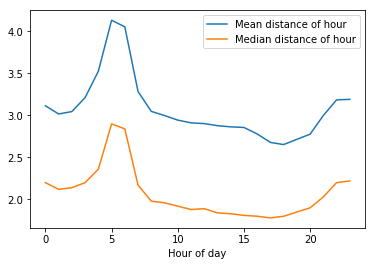

In [5]:
mean_dist_by_hour = df.groupby(['pick_up_hour'])['Trip_distance'].mean()
median_dist_by_hour = df.groupby(['pick_up_hour'])['Trip_distance'].median()

df_hour_dist = pd.concat([mean_dist_by_hour.rename('Mean distance of hour'),
                          median_dist_by_hour.rename('Median distance of hour')], axis=1)

df_hour_dist.index.names = ['Hour of day']

df_hour_dist.plot()
plt.show()



In [6]:
df_hour_dist

,Mean distance of hour,Median distance of hour
Hour of day,,
0,3.115276,2.20
1,3.017347,2.12
2,3.046176,2.14
3,3.212945,2.20
4,3.526555,2.36
5,4.133474,2.90
6,4.055149,2.84
7,3.284394,2.17
8,3.048450,1.98


As you can see from the above figure and table, there are two peaks for the trip distance. One is around 5AM, and another one is around midnight. 

People who live long from their working place need to get up early and commute to work, which probably caused the first peak period. The second peak period is around midnight. It might because the public tranportation is over for the day, people have to choose taxi to get to their destinations. 

You may also observe that the mean/median trip distance for the morning one is much greater than the evening one. We may guess that people taking taxi in the morning may use alternative transportation, like bus, train, etc., in the evening, as they are not in a rush to get back home.  

*Let's explore those trips that originate or terminate at one of the NYC area airports.*

We can use the RateCodeID (=2) to identify JFK airport.

In [7]:
filtered_idx = np.where(df['RateCodeID']==2)[0] # filter by RateCodeID to get JFK airport trips

df_airport = df.iloc[filtered_idx]

mean_fair = df_airport['Fare_amount'].mean()

print("total number of trips that originat or terminate at JFK airport: %d" % df_airport.shape[0])
print("average fair amount %s" % str(mean_fair))

total number of trips that originat or terminate at JFK airport: 4435
average fair amount 49.021871476888386


So we know that there are 4435 trips that originate or terminate at JFK airpot in September, 2015, and the average fair (exclude tip and toll fee) is $49.02.

*We can also try to find characteristics of these trips.*

Let's take a look at the trip distance first. 

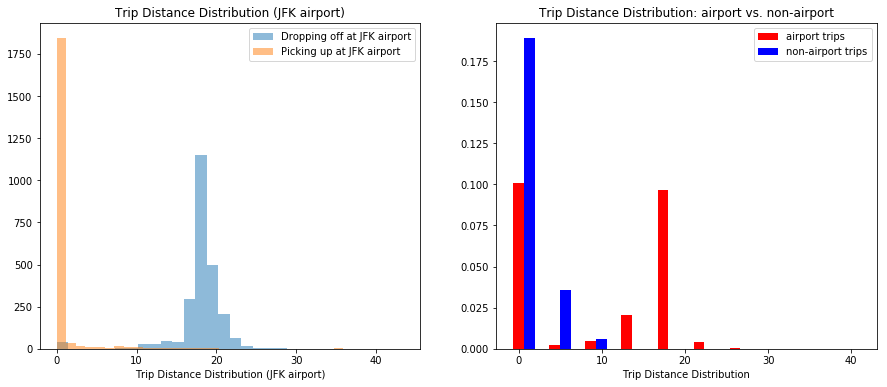

In [8]:


# count, division = np.histogram(df_airport['Trip_distance'], bins=30)
# print("Count in each bin:", count)
# print("borders for each bin: ", division)

import matplotlib.patches as mpatches
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.xlabel('Trip Distance Distribution (JFK airport)')
plt.title('Trip Distance Distribution (JFK airport)')


#plt.legend()

JFK_LONGITUDE_APPRO = -73.77
JFK_LATITUDE_APPRO = 40.65
def dropoff_is_airport(x):
    longitude = x.Dropoff_longitude
    latitude = x.Dropoff_latitude
    return (abs(longitude-JFK_LONGITUDE_APPRO)<0.05) & (abs(latitude-JFK_LATITUDE_APPRO)<0.05) 
   
airport_drop_off = df_airport.apply(dropoff_is_airport, axis=1)
df_tmp = pd.concat([df_airport, airport_drop_off.rename('airport_drop_off')], axis=1)
plt.hist(df_tmp.Trip_distance[df_tmp.airport_drop_off==True], alpha=0.5, bins=30)
plt.hist(df_tmp.Trip_distance[df_tmp.airport_drop_off==False], alpha=0.5, bins=30)

plt.legend(('Dropping off at JFK airport', 'Picking up at JFK airport'), loc='best')


plt.subplot(1,2,2)
plt.xlabel('Trip Distance Distribution')
plt.title('Trip Distance Distribution: airport vs. non-airport')


t = df[df['RateCodeID']!=2].Trip_distance
f1 = t[~((t-t.median()).abs()>3*t.std())]
f2 = df_airport.Trip_distance

bins = np.histogram(f2,normed=True)[1]
h2 = np.histogram(f2,bins=bins,normed=True)
h3 = np.histogram(f1,bins=bins,normed=True)

w = .3*(bins[1]-bins[0])

plt.bar(bins[:-1],h2[0],alpha=1,width=w,color='r')
plt.bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='b')
plt.legend(('airport trips', 'non-airport trips'), loc='best')




plt.show()



For the airport trips, I am interested to know which trips picking up at the airport and which trips are dropping off at the airport. From google map, it shows the longitude and lantitude of JFK international airport is around -73.77 and 40.65. Let's assume it located at the airport area at the range of plus/minus 0.05 coordinates. So we can identify if the airport is the origination or destination. 

It is interesting to know from the left figure that mostly the long distance trips are dropping off at the airport, while the short distance trips are picking at the airport. 

We can also compare the airport trips and non-airport trips as shown in the right figure. The airport trips count for most of the long distance trips.



#### Prediction Model

##### Question 4

- Build a derived variable for tip as a percentage of the total fare.
- Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample.



##### Answers to Q4

Let's build the derived target variable first.

In [9]:
df['tip_percentage'] = 100*df.Tip_amount/df.Total_amount

df['tip_percentage'].describe()


count    1.490754e+06
mean     6.653826e+00
std      8.875158e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: tip_percentage, dtype: float64

Next, we are going to build a predictive model for tip as a percentage of the total fare. There are basically four stages for bulding predictive models: data cleaning, feature engineering, building model, and results/error analysis. Let's go through these one by one.

**Data Cleaning**

What do we want to clean?

In [10]:
# print(df.isnull().any())
# print(df.describe())

We found there are null values in Ehail_fee, Trip_type, and tip_percentage. The maximum value of RateCodeID is 99, which is odd. And if you look at those money amounts (Fare_amount, Extra, MTA_tax, Tip_amount, Tolls_amount, improvement_surcharge, and Total_amount), you will find there are negative values in them, which is not making sense. Let's check those variables.

In [11]:
print(df[['Ehail_fee', 'tip_percentage']].isnull().apply(pd.Series.value_counts))
print("\n")
print("value counts for RateCodeID: \n", df.RateCodeID.value_counts())
print("\n")
print("number of negative Total_amount: %d" % sum(df['Total_amount']<0))
print("\n")
print(df[df.MTA_tax<0].MTA_tax.value_counts())
print("\n")
print(df[df.improvement_surcharge<0].improvement_surcharge.value_counts())

       Ehail_fee  tip_percentage
False        NaN         1490754
True   1494926.0            4172


value counts for RateCodeID: 
 1     1454464
5       33943
2        4435
3        1117
4         925
6          36
99          6
Name: RateCodeID, dtype: int64


number of negative Total_amount: 2417


-0.5    2187
Name: MTA_tax, dtype: int64


-0.3    2215
Name: improvement_surcharge, dtype: int64


- Ehail_fee: almost all the value for this variable is NaN -> remove this variable
- RateCodeID: replace 99 with 1 (the most frequently one)
- Total_amount: remove samples less than 0 (this will result in NaN in the target variable)
- Fare_amount, Extra,  Tip_amount, Tolls_amount: replace negative values with 0
- MTA_tax, improvement_surcharge: use the absolute value
- tip_percentage: this is the target variable -> remove those trips with NaN tip_percentage (due to Total_amount being 0). 

In [12]:

# let's define a function to clean the data 

def clean_data(df=df):
    data = df.copy()
    
    print("original shape", data.shape)
    
    # Ehail_fee
    print("droping Ehail_fee")
    data.drop(columns='Ehail_fee', inplace=True)
    
    # RateCodeID
    print("replacing invalide RateCodeID")
    data.RateCodeID.replace(to_replace=99, value=1, inplace=True)
    
    
    # Total_amount
    print("removing samples with negative total amount: %d" % sum(data.Total_amount<0))
    data = data[data.Total_amount>=0]
    
    # Fare_amount, Extra, Tip_amount, Tolls_amount
    data[data.Fare_amount<0] = 0
    data[data.Extra<0] = 0
    data[data.Tip_amount<0] = 0
    data[data.Tolls_amount<0] = 0
    
    # MTA_tax, improvement_surcharge
    data.MTA_tax = abs(data.MTA_tax)
    data.improvement_surcharge = abs(data.improvement_surcharge)
    
    # target variable: tip_percentag
    print("removing samples without target variable: %d" % sum(data.tip_percentage.isnull()))
    data.dropna(axis=0, how='all', subset=['tip_percentage'], inplace=True)
    
    print("final shape", data.shape)
    return data
    

**Feature Engineering**

In [13]:
# data.info()

data = clean_data(df)


original shape (1494926, 23)
droping Ehail_fee
replacing invalide RateCodeID
removing samples with negative total amount: 2417
removing samples without target variable: 4172
final shape (1488337, 22)


* Time variables
  - lpep_pickup_datetime -> pick_up_hour
  - Lpep_dropoff_datetime -> drop_off_hour
* Geograph variables
  - use geopy library to convert longitude and latitude to a representative place id
      - Pickup_longitude
      - Pickup_latitude          
      - Dropoff_longitude        
      - Dropoff_latitude

* Categorical variables
  - Label encoding 
      - VendorID
      - RateCodeID
      - Payment_type
      - Trip_type
      - Store_and_fwd_flag
  
* Numerical variables (others)


use [uszipcode](https://pypi.python.org/pypi/uszipcode) to download geographical infomation.

In [14]:
%%time
import time

import os.path
import pickle
path = './datasets/data_with_new_features.pkl'
import uszipcode

data = clean_data(df)

search = uszipcode.ZipcodeSearchEngine()
def get_geo_info(latitude, longitude):
    results = search.by_coordinate(latitude, longitude, radius=10, returns=2)
    if len(results) > 0:
        return results[0]['Zipcode']


# derived features
# Note: It took 1.5 hour to get all the zipcode info from longitude and latitude for the first time. It is quicker to use
# the data set that added already these new varialbes. For any new test dataset, you need to call this function to get 
# new derived features
def get_new_features(data=data):
    print("generating derived features...")
    print("add pick_up_hour...")
    data['pick_up_hour'] = data.lpep_pickup_datetime.apply(lambda x:time_to_hour(str(x)))
    print("add drop_off_hour...")
    data['drop_off_hour'] = data.Lpep_dropoff_datetime.apply(lambda x:time_to_hour(str(x)))
    print("add drop postal zip...")
    data['drop_postal_zip'] = data.apply(lambda x: get_geo_info(x.Dropoff_latitude, x.Dropoff_longitude), axis=1)
    print("add pick up postal zip...")
    data['pick_postal_zip'] = data.apply(lambda x: get_geo_info(x.Pickup_latitude, x.Pickup_longitude), axis=1)
    
    pickle.dump(data, open(path, 'wb'))
    print("done")
    return data



if os.path.isfile(path):
    print("loading...")
    data = pickle.load(open(path, 'rb'))
else:
    print("creating...")
    data = get_new_features(data)

data.reset_index(inplace=True)
print("done")


original shape (1494926, 23)
droping Ehail_fee
replacing invalide RateCodeID
removing samples with negative total amount: 2417
removing samples without target variable: 4172
final shape (1488337, 22)
loading...
done
CPU times: user 3.05 s, sys: 1.42 s, total: 4.47 s
Wall time: 4.82 s


In [15]:
# encode categorical data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['drop_postal_zip'].fillna('', inplace=True)
data['pick_postal_zip'].fillna('', inplace=True)
le.fit(data['drop_postal_zip'].append(data['pick_postal_zip']))

pd.options.mode.chained_assignment = None

def transform(X):
    categorical_features = ['VendorID', 'RateCodeID', 'Payment_type', 'Store_and_fwd_flag']
    X['Store_and_fwd_flag'].replace(to_replace='Y', value=1, inplace=True)
    X['Store_and_fwd_flag'].replace(to_replace='N', value=0, inplace=True)
    X['Store_and_fwd_flag'].fillna(0, inplace=True)

    X['drop_postal_zip'].fillna('', inplace=True)
    X['pick_postal_zip'].fillna('', inplace=True)
    X['drop_postal_zip_encode'] = le.transform(X['drop_postal_zip'])
    X['pick_postal_zip_encode'] = le.transform(X['pick_postal_zip'])

    new_features = ['pick_up_hour', 'drop_off_hour', 'drop_postal_zip_encode', 'pick_postal_zip_encode'] 

    # Normalize numerical features, exclude tip_amount and total_amount
    numerical_features = ['Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'improvement_surcharge', 'Tolls_amount']
    numerical_features_normed = ['Trip_distance_norm', 'Fare_amount_norm', 'Extra_norm', 'MTA_tax_norm', 
                                 'improvement_surcharge_norm', 'Tolls_amount_norm']

    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler()
    X_scale = scalar.fit_transform(X[numerical_features])
    
    data_tmp = pd.concat([X, pd.DataFrame(columns=numerical_features_normed, data=X_scale, index=X.index.values)], axis=1)
    
   # add all features together
    return data_tmp[new_features+categorical_features+numerical_features_normed]
#     X_all = data_tmp[new_features+categorical_features+numerical_features_normed]
#     y_all = data_tmp.tip_percentage





**Build prediction model**

- In our final training data set, we have 1488339 samples, and 14 features for training. Within these samples, there are 602738 trips with tips, and 885601 without any tips. 
- We can build a regression model for all trips with tips. 
- We can also try to build a classificatioin model for w/i tip or w/o tip.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488339 entries, 0 to 1488338
Data columns (total 26 columns):
index                    1488339 non-null int64
VendorID                 1488339 non-null int64
lpep_pickup_datetime     1488339 non-null object
Lpep_dropoff_datetime    1488339 non-null object
Store_and_fwd_flag       1488333 non-null object
RateCodeID               1488339 non-null int64
Pickup_longitude         1488339 non-null float64
Pickup_latitude          1488339 non-null float64
Dropoff_longitude        1488339 non-null float64
Dropoff_latitude         1488339 non-null float64
Passenger_count          1488339 non-null int64
Trip_distance            1488339 non-null float64
Fare_amount              1488339 non-null float64
Extra                    1488339 non-null float64
MTA_tax                  1488339 non-null float64
Tip_amount               1488339 non-null float64
Tolls_amount             1488339 non-null float64
improvement_surcharge    1488339 non-null float6

**Classification Model**

In [17]:
# Random Forests Classification

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import recall_score

X=data.drop(['tip_percentage'], axis=1)
y=(data.tip_percentage>0)*1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# clf = LogisticRegression()

X_train_tf = transform(X_train)
X_test_tf = transform(X_test)

print("transformed training shape:", X_train_tf.shape)
print("transformed testing shape:", X_test_tf.shape)

clf = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=0)

clf.fit(X_train_tf, y_train)
y_pred = clf.predict(X_test_tf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



# scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=2, return_train_score=True)

transformed training shape: (1190671, 14)
transformed testing shape: (297668, 14)
             precision    recall  f1-score   support

          0       1.00      0.90      0.94    177222
          1       0.87      1.00      0.93    120446

avg / total       0.94      0.94      0.94    297668

[[158800  18422]
 [   598 119848]]


In [18]:
# Hyperparameter fine tuning
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[5,10], 'max_depth':[5, 10, 20]}

clf_tune = GridSearchCV(clf, parameters)

clf_tune.fit(X_train_tf, y_train)
y_pred = clf.predict(X_test_tf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.90      0.94    177222
          1       0.87      1.00      0.93    120446

avg / total       0.94      0.94      0.94    297668

[[158800  18422]
 [   598 119848]]


#### Results
As shown above in the confusion matrix, the RandomForest classifier acheived 0.94 both average precision and recall. 

Let's see the importance features from RandomForests

In [19]:

print(dict(zip(X_train_tf.columns.values, clf.feature_importances_)))


{'pick_up_hour': 0.001203118590314644, 'drop_off_hour': 0.001067029031789699, 'drop_postal_zip_encode': 0.02287923200336276, 'pick_postal_zip_encode': 0.029837738953622177, 'VendorID': 0.0004249608225232695, 'RateCodeID': 0.0024255654655861874, 'Payment_type': 0.9083828481718019, 'Store_and_fwd_flag': 2.522899420310652e-05, 'Trip_distance_norm': 0.018712144176947193, 'Fare_amount_norm': 0.008815671768404818, 'Extra_norm': 0.0002533188998020082, 'MTA_tax_norm': 0.003967346712251224, 'improvement_surcharge_norm': 0.0016191507228022002, 'Tolls_amount_norm': 0.0003866456865890299}


The most important feature is 'Payment_type', and followed by the derived geographical info, 'drop_postal_zip_encode' and 'pick_postal_zip_encode'. 

Let's see how the Payment_type and geographical info affect the results

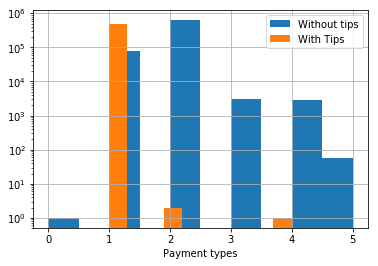

In [20]:
plt.figure()
X_train.Payment_type.groupby(by=y_train).hist(log=True)
plt.xlabel('Payment types')
plt.legend(('Without tips', 'With Tips'), loc='best')
plt.show()


Most of the tips are paid by credit card. We could guess that the tip may calculated automatically when you charged by a credit card. 

Next, let's see how different areas in Manhatton affect the amount of tips. We have retried all the zip codes associated with the Longitude and latitude in the data sets. Let's compare the upper east side and lower east side. 

<Figure size 432x288 with 0 Axes>

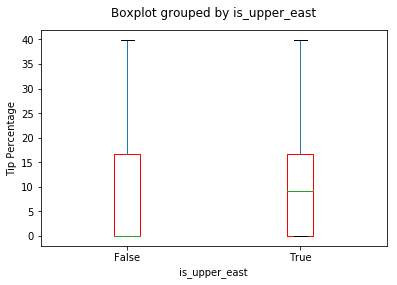

In [21]:
upper_east_zipcode = ['10021', '10028', '10044', '10065', '10075', '10128']

marks1 = X_train.drop_postal_zip.apply(lambda x: str(x) in upper_east_zipcode)
marks2 = X_train.pick_postal_zip.apply(lambda x: str(x) in upper_east_zipcode)

data['is_upper_east'] = marks1 | marks2

plt.figure()
boxprops = dict(linestyle='-', color='k')
medianprops = dict(linestyle='-', color='k')
bp = data.iloc[y_train.index.values].loc[data.tip_percentage<40].boxplot(column=['tip_percentage'], 
                                                                         by='is_upper_east', 
                                                                         grid=False,
                                                                         boxprops=boxprops, medianprops=medianprops,
                                                                         return_type='dict'
                                                                        )


[[item.set_color('r') for item in bp[key]['boxes']] for key in bp.keys()]

plt.title('')
plt.ylabel('Tip Percentage')


plt.show()



So the trips picked up or dropped off at Manhatton upper east side is trending to give more Tips, which aligns to our expectation. 


**Linear Regression Model**

In [25]:
# Linear Regression for tip_percentage
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

idx = np.where(data.tip_percentage>0)[0]
X=data.iloc[idx,].drop(['tip_percentage'], axis=1)
y=data.iloc[idx,].tip_percentage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# clf = LogisticRegression()

X_train_tf = transform(X_train)
X_test_tf = transform(X_test)
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train_tf, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test_tf)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 32.74
Variance score: 0.03


## Search

### Question 5 (Option C)

- We’re thinking about promoting ride sharing. Build a function that given point a point P, find the k trip origination points nearest P.
- For this question, point P would be a taxi ride starting location picked by us at a given LAT-LONG.
- As an extra layer of complexity, consider the time for pickups, so this could eventually be used for real time ride sharing matching.
- Please explain not only how this can be computed, but how efficient your approach is (time and space complexity)


### Answers to Q5

The searching approach is as followd,

- calculate all the distances from P to all other pionts (O(N)).
- sort the distances in ascending order (O(NlogN))
- get the top k trips
 

In [23]:
# let's derive a speed variable

def get_speed(x):
    try:
        dt1 = datetime.datetime.strptime(x.Lpep_dropoff_datetime, "%Y-%m-%d %H:%M:%S")
        dt2 = datetime.datetime.strptime(x.lpep_pickup_datetime, "%Y-%m-%d %H:%M:%S")
        delta_hour = (dt1-dt2).total_seconds()/3600.0
        return x.Trip_distance/delta_hour
    except Exception as e:
        return 0

data['speed'] = data.apply(get_speed, axis=1)
median_mph = data.speed.median()
data.speed.replace(0, median_mph, inplace=True)
data.speed.describe()

count    1.488339e+06
mean     1.590009e+01
std      2.156466e+02
min      4.170866e-04
25%      9.460751e+00
50%      1.177112e+01
75%      1.506522e+01
max      2.026800e+05
Name: speed, dtype: float64

In [24]:
K = 3
from math import radians, acos, sin, cos
import datetime
from datetime import timedelta


def get_distance(p1, p2):
    R = 6373.0
    lat1, lon1 = radians(p1[0]), radians(p1[1])
    lat2, lon2 = radians(p2[0]), radians(p2[1])
    
    dist = R * acos(sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(lon1 - lon2))
    return dist

def get_nearest_trips(longitude, latitude):
    dists = []
    p_orig = (longitude, latitude)
    for index, row in data.iterrows():
        lon = row.Pickup_longitude
        lan = row.Pickup_latitude
        # consider time for pickups: calculate the time needed to get to the pickup location. Ignore it if cannot 
        # get to the location in time
        current = datetime.datetime.now()
        try:
            dt = datetime.datetime.strptime(row.lpep_pickup_datetime, "%Y-%m-%d %H:%M:%S")

            delta = current - dt
            p = (lon, lan)        
            dist = get_distance(p_orig, p)
            speed = row.speed if row.speed<100 else median_mph # due to pickup/dropoff time inaccurate

            if dist*3600.0/speed < delta.total_seconds():
                dists.append((index, dist))
                
        except Exception as e:
#             print("no pickup time: %s" % str(e))
            continue
    return sorted(dists, key=lambda x: x[1])[:K]


get_nearest_trips(40.684956, -73.979485)
        
    
    

[(1201, 8667.021599992891),
 (2035, 8667.021599992891),
 (3041, 8667.021599992891)]

**Consider time to pickup**

In order to implement ride sharing, we need to consider the time to pickup. You should pick up the passengers that are close to you, and you can get to the pickup location in time. So we need to derive a new variable, speed, by the 'Trip_distance' and time spent (Lpep_dropoff_datetime - lpep_pickup_datetime), then calculate the time needed to get to the pickup location. 


**Search Optimization**

The time complexity of the above solution is O(NlogN), where is N is the sample size. The space complexity is O(N).

We can use quickselect algorithm to optimize approximately to O(N). 


